# LAPS script for the main run
Authors: Gabi Mukai, Johanna Wren, Taylor Ely, and Don Kobayashi

Date: May 21, 2025

## Description
 
Script to run the main run for the LAPS project. This code is based on code developed during the sensitivity analysis and from Gabi's bumphead parrotfish Wake script. 

This script advects particles in pre-defined locations at a pre-defined depth using HYCOM currents stored on file. The trajectories are saved as tarr files. This script contains a particle age (PLD) but no land avoidance and uses 2D passive dispersal with diffusivity. 

The script also calculates cumulative distance traveled. 

In [8]:
import numpy as np
import numpy.ma as ma
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
from scipy import interpolate
import math 
from pathlib import Path

from parcels import FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, DiffusionUniformKh, Variable, Field, GeographicPolar, Geographic
from datetime import timedelta as timedelta
import datetime
from parcels.tools.converters import TimeConverter
import glob
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from os.path import isfile
import pytz
from os import path


## Delete Kernels

In [9]:

# Delete Error
def DeleteErrorParticle(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

# Delete Kernel
def DeleteParticle(particle, fieldset, time):
    print('deleted particle')
    particle.delete()



In [10]:
# Define start and end dates
startDate = '1993-01-01'
endDate = '1993-03-31'

#file = glob.glob("/home/esd_data/Hycom_Wake/HYCOM_Wake_*.nc")
# create list of file paths between the start and end time in seconds sincce epoch 
expected_files = [f"~/Documents/Glorys/Glorys_1993/GLORYS_REANALYSIS_{filedate.strftime("%Y-%m-%d")}.nc" for filedate in pd.date_range(start=startDate, end=endDate, freq='D')]
#print(expected_files[0:5])
# Filter the list to just the files that actually exist. (This is for when you remove NA files)
#actual_files = [f for f in expected_files if isfile(f)]

ds1 = xr.open_mfdataset(expected_files)  # this puts the opendap data into a xarray dataset
print(ds1)
myDat1 = ds1.sel(**{'time': slice(startDate,endDate)})


<xarray.Dataset> Size: 42GB
Dimensions:    (time: 90, depth: 50, latitude: 481, longitude: 1201)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 2kB 0.0 0.08333 0.1667 ... 39.83 39.92 40.0
  * time       (time) datetime64[ns] 720B 1993-01-01 1993-01-02 ... 1993-03-31
  * longitude  (longitude) float32 5kB 120.0 120.1 120.2 ... 219.8 219.9 220.0
Data variables:
    uo         (time, depth, latitude, longitude) float64 21GB dask.array<chunksize=(1, 50, 481, 1201), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 21GB dask.array<chunksize=(1, 50, 481, 1201), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    refer

In [11]:
#test=ds1["vo"][:1, :1, ::3, ::3]
#test.plot()#

print(myDat1)

<xarray.Dataset> Size: 42GB
Dimensions:    (time: 90, depth: 50, latitude: 481, longitude: 1201)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 2kB 0.0 0.08333 0.1667 ... 39.83 39.92 40.0
  * time       (time) datetime64[ns] 720B 1993-01-01 1993-01-02 ... 1993-03-31
  * longitude  (longitude) float32 5kB 120.0 120.1 120.2 ... 219.8 219.9 220.0
Data variables:
    uo         (time, depth, latitude, longitude) float64 21GB dask.array<chunksize=(1, 50, 481, 1201), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 21GB dask.array<chunksize=(1, 50, 481, 1201), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    refer

In [12]:
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lon': 'longitude',
              'lat': 'latitude',
              'time': 'time',
              'depth': 'depth'}

fieldset = FieldSet.from_xarray_dataset(myDat1, variables, dimensions)



In [13]:

# Set the eddy diffusivity
kh = 10.0   # This is the eddy diffusivity in m2/s
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
#zonal follows lat
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical') 



In [14]:


class DisplacementParticle(JITParticle):
    #dU = Variable('dU', to_write = False)
    #dV = Variable('dV', to_write = False)
    #d2s = Variable('d2s', initial=1e3, to_write = False)
    age = Variable('age', dtype=np.float32, initial= 0., to_write = False)
    cycle_phase=Variable('cycle_phase', dtype=np.float32, initial=0., to_write = False)
    releaseSite = Variable('releaseSite', dtype=np.int32, to_write = False)
    distance = Variable('distance', dtype=np.int32, initial=0.) # not calculating distance for now but left this in
    prev_lat = Variable('prev_lat', initial=0., to_write=False)  
    prev_lon = Variable('prev_lon', initial=0., to_write=False)
    #f = Variable('f', dtype=np.int32, to_write = False)
    #driftlayer = Variable('driftlayer', dtype=np.int32, to_write = False)


In [15]:

# Read in file with release locations
source_loc = pd.read_csv('../LAPS_release_sites_noHI.csv')
# Number of particle released per location
npart_perlayer = 250
npart = 2*npart_perlayer

# Release location from the file read in above
lon = np.repeat(source_loc.Lon, npart)
lat = np.repeat(source_loc.Lat,npart)
site = np.repeat(source_loc.Site,npart)
# Start date for release. Since we are releasing every set number of days the repeatdt version was simplest
#start_date = 0
dlayer = [0.25]*(len(source_loc)*npart)
driftlayers = [10, 20]  # Define the layers
#repeating_layers = driftlayers * (len(source_loc)*npart_perlayer)
depth=[1]*len(lon)

repeatdt = timedelta(days=1)

print("called in release points")

called in release points


In [16]:
len(depth)

20500

In [17]:
print("create pset now")
pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, depth=depth, repeatdt=repeatdt)

print("create kernels")
kernels = [AdvectionRK4, DiffusionUniformKh, DeleteErrorParticle]


create pset now
create kernels


In [18]:
output_file = pset.ParticleFile(name="testLAPS.zarr", outputdt=timedelta(hours=0.5))

In [ ]:
model_dt=timedelta(minutes=10)

run_days = 10
print("start execute")
pset.execute(kernels,
            runtime=timedelta(days=run_days),
            dt=model_dt, 
            output_file=output_file)
pset.repeatdt = None

'''
pset.execute(kernels,
            runtime=timedelta(days=31+1),
            dt=model_dt, 
            output_file=output_file)
'''
#data_xarray = xr.open_zarr("Wake_1992_n10_kh10_Oct_Feb_bounce5_2_2.zarr")
#data_xarray.to_netcdf("Wake_1992_n10_kh10_Oct_Feb_bounce5_2_2.nc")


start execute
INFO: Output files are stored in testLAPS.zarr.
  1%|          | 9600.0/864000.0 [01:45<50:25, 282.38it/s]  

In [ ]:
test=xr.open_zarr("testLAPS.zarr")
#test.to_netcdf('testLAPS.nc')
test

<xarray.Dataset> Size: 39MB
Dimensions:     (trajectory: 4100, obs: 480)
Coordinates:
  * obs         (obs) int32 2kB 0 1 2 3 4 5 6 7 ... 473 474 475 476 477 478 479
  * trajectory  (trajectory) int64 33kB 410 411 412 413 ... 4506 4507 4508 4509
Data variables:
    lat         (trajectory, obs) float32 8MB dask.array<chunksize=(410, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 8MB dask.array<chunksize=(410, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 16MB dask.array<chunksize=(410, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 8MB dask.array<chunksize=(410, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4DiffusionUniformKhDeleteEr...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [ ]:
hycom=xr.open_dataset('~/Downloads/HYCOM_LAPS_000001.nc')
hycom2=xr.open_dataset('~/Downloads/HYCOM_LAPS_059168.nc')
hycom2.TIME

<xarray.DataArray 'TIME' (TIME: 1)> Size: 8B
array(['2012-12-31T21:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * TIME     (TIME) datetime64[ns] 8B 2012-12-31T21:00:00
Attributes:
    axis:           T
    long_name:      Time
    time_origin:    01-JAN-1970 00:00:00
    standard_name:  time

 ...]

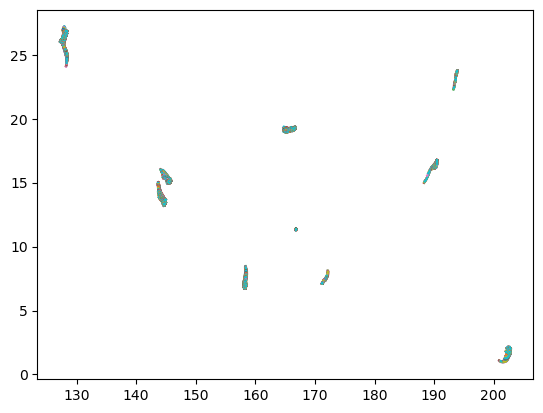

In [ ]:
plt.plot(test['lon'].T, test['lat'].T)